In [1]:
import os, sys
# notebooks/에서 한 단계 위로 올라간 폴더를 PATH에 추가
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
from env.custom_maze_env import CustomMazeEnv
from env.get_retina_image import reconstruct
from minigrid.wrappers import RGBImgPartialObsWrapper, ImgObsWrapper
import time
import matplotlib.pyplot as plt
import numpy as np
from IPython import display


# 환경 생성 후 map visualize

Start: (7, 9) Goal: (0, 3)


(np.float64(-0.5), np.float64(415.5), np.float64(415.5), np.float64(-0.5))

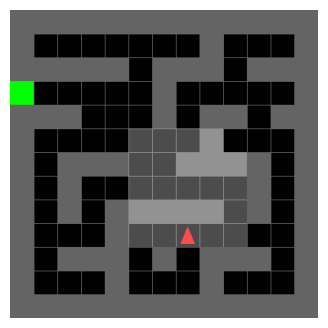

In [3]:
env = CustomMazeEnv(
    layout_id="d",
    goal_pos=(0,3),
    view_size=5,
    max_steps=250,
    tile_size=32,
    render_mode="rgb_array"    # ← 이 인자로 배열 반환이 활성화
)

obs, _ = env.reset(seed=10)
print("Start:", obs["position"], "Goal:", env.goal_pos)

img = env.render()           # 이제 numpy RGB array 반환!
plt.figure(figsize=(4,4))
plt.imshow(img)
plt.axis("off")


## 환경 설명

obs['view']는 3가지 key를 가진 딕셔너리
> obs['view']['image'] : (5, 5, 3) 모양의 격자 기반의 관측 정보( “픽셀 사진” 아님)

> obs['view']['direction'] : int로 방향을 매핑(left : 2 , up : 3, down : 1, right :0)

> obs['view']['mission'] : 사전 설정한 목표

# 환경 1인칭 view(Top_down)

Start: (3, 7)
Goal: (0, 3)


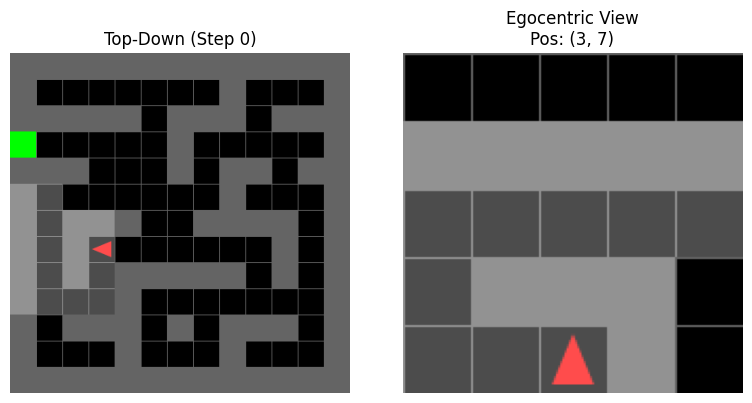

In [4]:
# 1) 원본 env
base_env = CustomMazeEnv(
    layout_id="d",
    goal_pos=(0,3),
    view_size=5,
    max_steps=250,
    tile_size=32,
    render_mode="rgb_array"
)

# 2) 픽셀Obs 래퍼 씌우기
env = RGBImgPartialObsWrapper(base_env, tile_size=32)

# 3) reset/step 은 래퍼 env로
obs, _ = env.reset(seed=40)
print("Start:", obs["position"])

# 4) 원본 goal_pos 읽기 (unwrap)
print("Goal:", env.unwrapped.goal_pos)

# 5) 탑다운 렌더링
top_down_view = env.render()
fp_view = obs['image']  

# 2열 subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
ax1.imshow(top_down_view)
ax1.set_title(f"Top-Down (Step {obs['timestep']})")
ax1.axis("off")

ax2.imshow(fp_view)
ax2.set_title(f"Egocentric View\nPos: {obs['position']}")
ax2.axis("off")

plt.tight_layout()
plt.show()


# 1인칭 egocentric_view

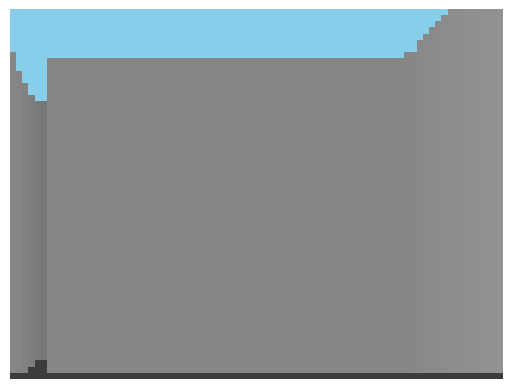

In [5]:
fp_view = obs['image']  
egocentric_view = reconstruct(fp_view)
plt.imshow(egocentric_view)
plt.axis("off")
plt.show()

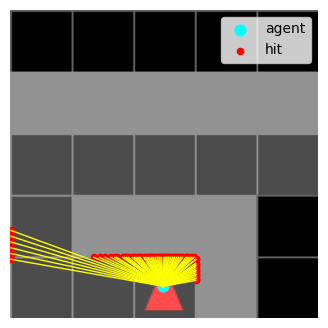

(60, 80, 3)


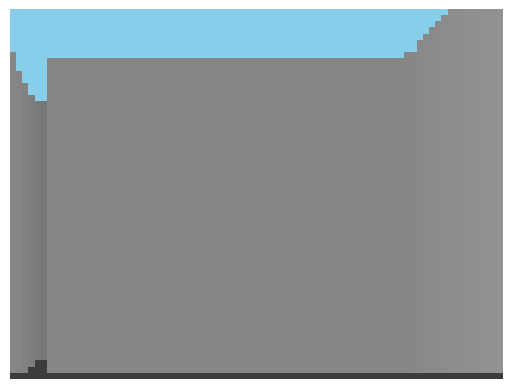

In [6]:
fp_view = obs['image']  
egocentric_view = reconstruct(fp_view,render_mode=True)
print(egocentric_view.shape)
plt.imshow(egocentric_view)
plt.axis("off")
plt.show()

(60, 80)


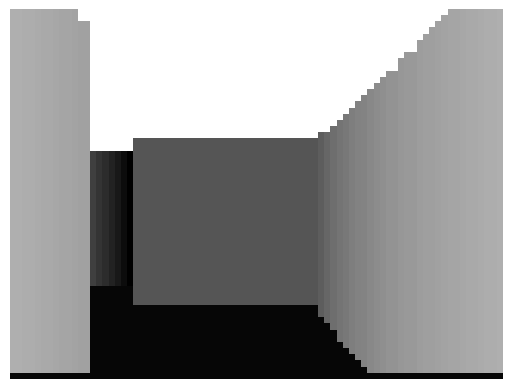

In [7]:
fp_view = obs['image']  
egocentric_view = reconstruct(fp_view, render_chanel=1)
print(egocentric_view.shape)
plt.imshow(egocentric_view,cmap="gray")
plt.axis("off")
plt.show()

# 환경 내에서 이동하기

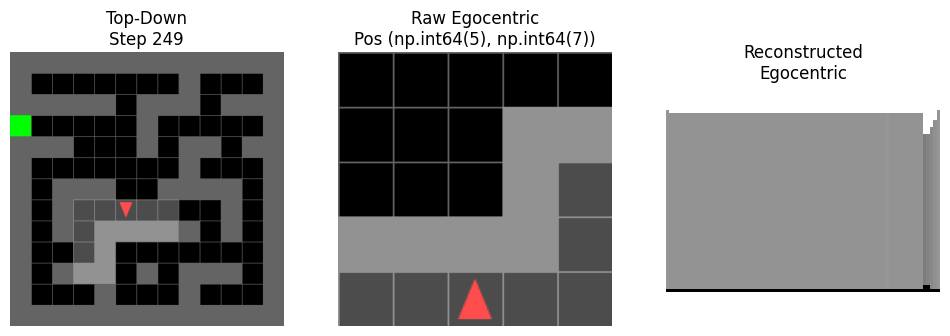

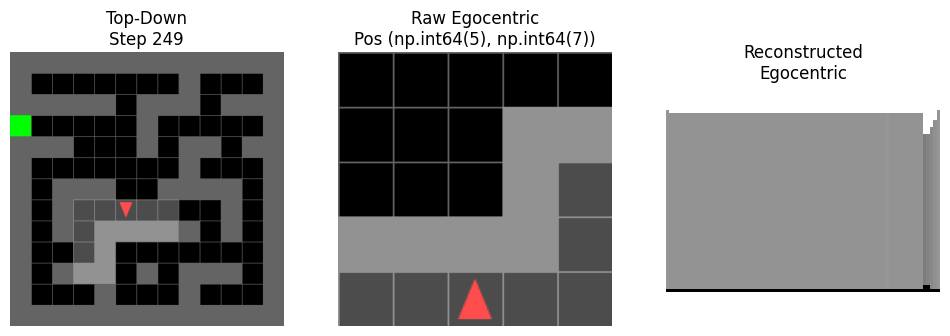

In [7]:
# 1) Base env + 픽셀Obs 래퍼
base_env = CustomMazeEnv(
    layout_id="d",
    goal_pos=(0,3),
    view_size=5,
    max_steps=250,
    tile_size=32,
    render_mode="rgb_array"
)
env = RGBImgPartialObsWrapper(base_env, tile_size=32)

# 2) 초기 reset
obs, _ = env.reset(seed=40)

# 3) 플롯 준비
plt.ion()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))

done = False
while not done:
    # 화면 클리어
    display.clear_output(wait=True)
    
    # 탑다운 뷰 얻기
    top_down = base_env.render()      # (H, W, 3) uint8

    # 원본 1인칭 픽셀 뷰
    fp_view = obs["image"]            # (tile_size, tile_size, 3)

    # reconstruct 결과 (e.g. grayscale)
    egocentric_view = reconstruct(fp_view, render_chanel=1)
    # egocentric_view.shape == (tile_size, tile_size)

    # 1) Top-down
    ax1.clear()
    ax1.imshow(top_down)
    ax1.set_title(f"Top-Down\nStep {obs['timestep']}")
    ax1.axis("off")

    # 2) Raw egocentric
    ax2.clear()
    ax2.imshow(fp_view)
    ax2.set_title(f"Raw Egocentric\nPos {obs['position']}")
    ax2.axis("off")

    # 3) Reconstructed view
    ax3.clear()
    ax3.imshow(egocentric_view, cmap="gray")
    ax3.set_title("Reconstructed\nEgocentric")
    ax3.axis("off")
    
    display.display(fig)
    #plt.pause(0.1)

    # 다음 스텝
    action = env.action_space.sample()
    obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    if reward > 0:
        print(f"🎉 Goal reached at step {obs['timestep']} Pos {obs['position']}")

plt.ioff()